In [48]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import freqz, butter, firwin
from scipy import signal
from scipy.fft import fft, fftfreq, ifft

import xarray as xr
from eofs.standard import Eof
import pandas as pd

import xarray as xr
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import qr, solve_triangular
import numpy as np
import cartopy.crs as ccrs
from scipy.optimize import newton
import copy

In [2]:
def plotter(x, y, xlabel, ylabel, title):
    plt.figure()
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# Assignment 4: 
## - Aditya Moger 20211062


Using the PC1 signal that you have created in the previous assignment.

1. Write a function to create the appropriate time periods to assign on the x-axis for an amplitude spectrum.

2. Plot the amplitude spectrum of PC1, note the main spectral peaks and suggest physical reasons for these peaks.

In [3]:
# def make_time_and_freq_axis(sampling_frequency, signal_frequency):

#     time_step = 1/ sampling_frequency
#     number_of_samples = int(sampling_frequency / signal_frequency)

#     time_array = np.linspace(0, (number_of_samples-1)* time_step, number_of_samples)

#     frequency_step = sampling_frequency / number_of_samples
#     freq_array = np.linspace(0, (number_of_samples-1)* frequency_step, number_of_samples)

#     return time_array, freq_array

In [156]:
sst = xr.open_dataset('test.nc', engine='scipy').sst
pc1=np.loadtxt('pc1_sst.txt')
out=fft(pc1)

In [199]:
def make_x_axis(signal, delta_t):
    time = np.arange(0, signal.shape[-1]) * delta_t

    freq = fftfreq(time.shape[0], d=delta_t)

    first_negative_index = np.argmax(freq < 0)
    frequency_axis =freq[0:first_negative_index]
    
    return frequency_axis, first_negative_index, time

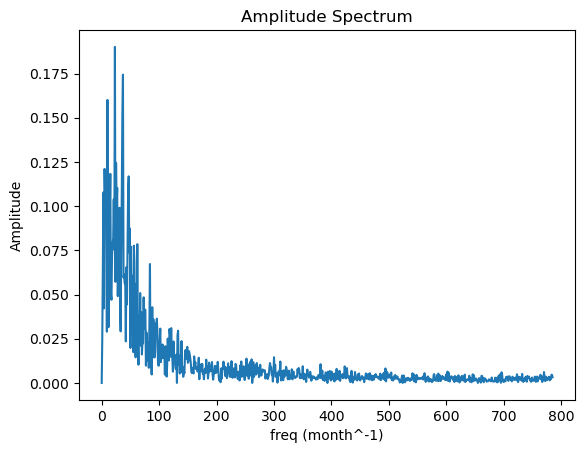

In [200]:
freq_axis_monthly, fft_slicer, time = make_x_axis(pc1, delta_t=1/ 1572) 
#there are 1572 months in our data set and one data point per month, hence 1/1572 is out delta_t.

signalFFT = fft(pc1) / time.shape[0]

fft_slice = signalFFT[0:fft_slicer]

plotter(freq_axis_monthly, np.abs(fft_slice), "freq (month^-1)", "Amplitude", "Amplitude Spectrum")

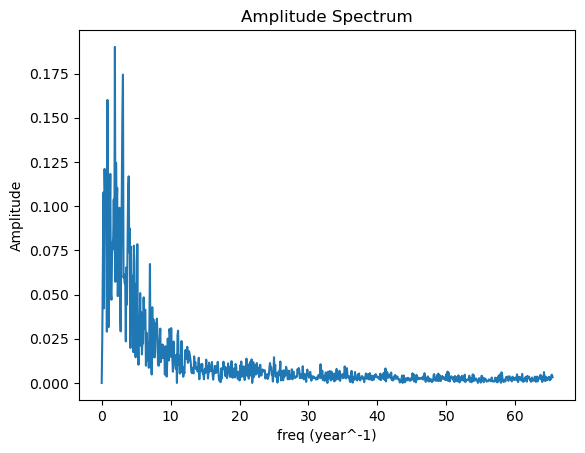

In [201]:
freq_axis_yearly, fft_slicer, time = make_x_axis(pc1, delta_t=12/ 1572) 
#there are 1572 months and 131 years in our data set and one data point per month, hence 12/1572 = 1/131 is out delta_t.

signalFFT = fft(pc1) / time.shape[0]
fft_slice = signalFFT[0:fft_slicer]

plotter(freq_axis_yearly, np.abs(fft_slice), "freq (year^-1)", "Amplitude", "Amplitude Spectrum")


The above is one way of representation, each value of x is the represents the amplitude of the sin function with periodicity = "value on x axis".
Another way to look at it is given below.

In [215]:
def make_x_axis_freq_oriented(signal, delta_t):
    time = np.arange(0, signal.shape[-1]) * delta_t

    freq = fftfreq(time.shape[0], d=delta_t)

    first_negative_index = np.argmax(freq < 0)
    frequency_axis=[]
    for i in range(0,len(freq[0:first_negative_index])):
        frequency_axis.append(1/freq[i])
    
    
    return frequency_axis, first_negative_index, time

    

C:\Users\adity\AppData\Local\Temp\ipykernel_2448\343360151.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  frequency_axis.append(1/freq[i])


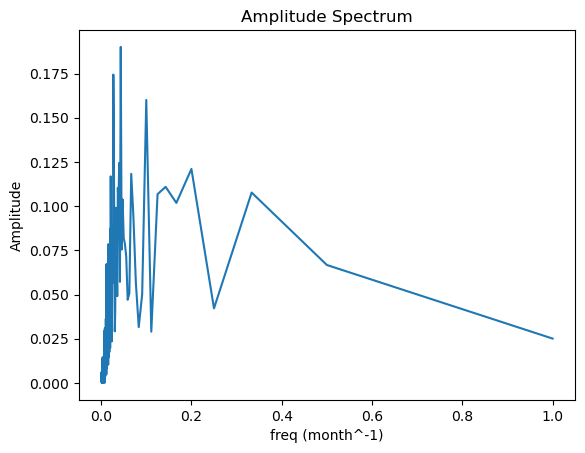

In [216]:
freq_axis_monthly_freqoriented, fft_slicer, time = make_x_axis_freq_oriented(pc1, delta_t=1/ 1572) 
#there are 1572 months in our data set and one data point per month, hence 1/1572 is out delta_t.

signalFFT = fft(pc1) / time.shape[0]

fft_slice = signalFFT[0:fft_slicer]


plotter(freq_axis_monthly_freqoriented, np.abs(fft_slice), "freq (month^-1)", "Amplitude", "Amplitude Spectrum")

Here the X axis represents the freq in per months, i.e., 1/month indicies.

In [207]:
index_of_max= np.argmax(np.abs(signalFFT))
freq_axis_monthly[index_of_max], freq_axis_yearly[index_of_max]

(23.0, 1.9166666666666665)

So the peak of the amplitude spectrum occurs at frequency of roughly 2 years or 24 months. A major component of the variation of SST data occurs every 2 years, which is the frequency of ENSO events!
<br>
Lets us look at the next 4 peaks as well.

In [205]:
lst= pd.Series(np.abs(fft_slice))
indices = lst.nlargest(5)
five_maxes_index= indices.index.values.tolist()

In [219]:
five_maxes_index
for i in range(0, len(five_maxes_index)):
    print(i+1, "th maximum ||","monthly frequency = occurs every", freq_axis_monthly[five_maxes_index[i] +1]," months",", yearly frequency = occurs every", freq_axis_yearly[five_maxes_index[i] +1], " years")

1 th maximum || monthly frequency = occurs every 24.0  months , yearly frequency = occurs every 2.0  years
2 th maximum || monthly frequency = occurs every 38.0  months , yearly frequency = occurs every 3.1666666666666665  years
3 th maximum || monthly frequency = occurs every 11.0  months , yearly frequency = occurs every 0.9166666666666666  years
4 th maximum || monthly frequency = occurs every 37.0  months , yearly frequency = occurs every 3.083333333333333  years
5 th maximum || monthly frequency = occurs every 26.0  months , yearly frequency = occurs every 2.1666666666666665  years


ENSO events occur with periodicities of 2-4 years and we see that some of the top 5 peaks show 2 to 3 year periodicities which line up with ENSO.<br>
While the 11 months roughly 1 year periodicity is most likely due to seasonal variation in the climate.


3. Design a 4-th order low-pass butterworth filter with a cutoff of 6 years. Filter PC1 with this filter using both regular and zero-phase filtering as described in class. Plot the error between the two kinds of filtering.


### Low pass filter
Following is for low pass 4th degree butterworth filter

In [162]:
sos = signal.butter(4, 1/72, 'low', fs=1, output='sos')
filtered_regular_low = signal.sosfilt(sos, pc1)

b, a = signal.butter(4, 1/72, 'low', fs=1)
filtered_zerophase_low = signal.filtfilt(b, a, pc1, padlen=None)


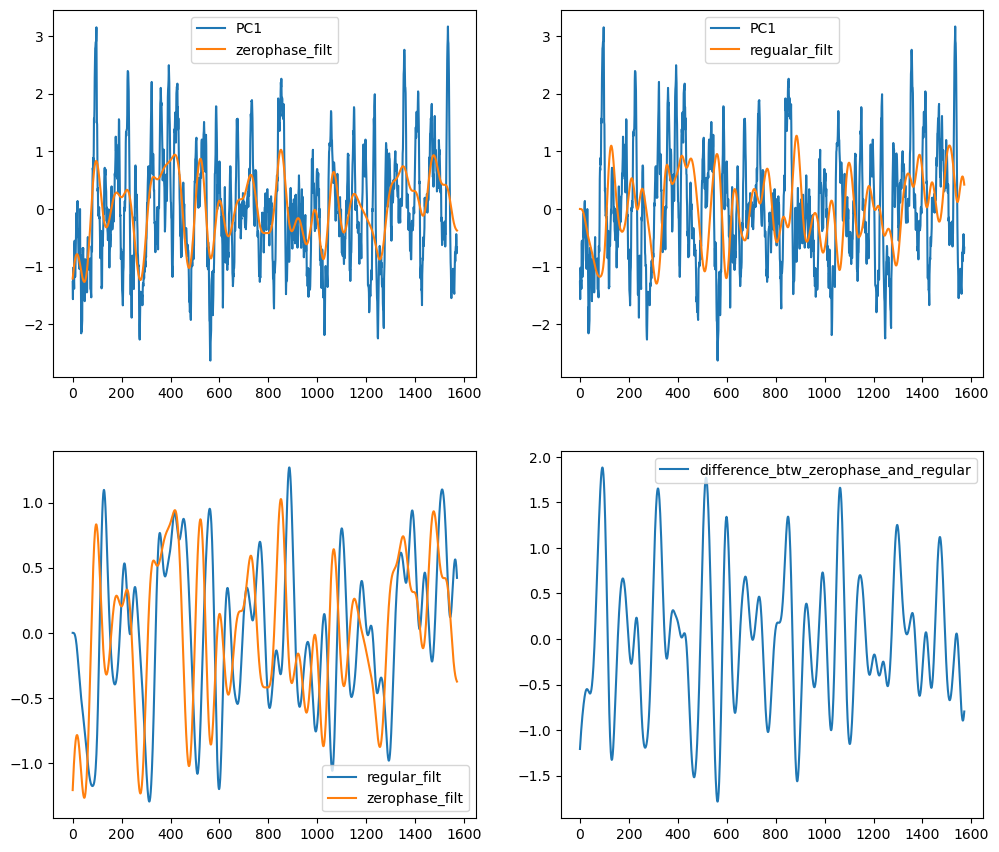

In [163]:
fig, ax= plt.subplots(nrows=2, ncols=2, figsize=(12,10.5))

ax[0,0].plot(pc1, label="PC1")
ax[0,0].plot(filtered_zerophase_low, label="zerophase_filt")
ax[0,0].legend()

ax[0,1].plot(pc1, label="PC1")
ax[0,1].plot(filtered_regular_low, label="regualar_filt")
ax[0,1].legend()

ax[1,0].plot(filtered_regular_low, label="regular_filt")
ax[1,0].plot(filtered_zerophase_low, label="zerophase_filt")
ax[1,0].legend()

ax[1,1].plot(filtered_zerophase_low - filtered_regular_low, label="difference_btw_zerophase_and_regular")

#ax[1,1].plot(filtered_regular_low)
#ax[1,1].plot(filtered_zerophase_low)
#ax[1,1].plot(pc1)

ax[1,1].legend()

We see a phase difference between regular and zerophase filter. Let's try and find how much the phase shift is.
<br>
Method employed:<br>
1. Shift all values by some values, say "shift". 
2. If no point exists "shift" many points before a given point, set its new value to 0. 
3. This method is very crude but gives us a rough idea of the phase shift.

In [108]:
def create_shifted_array(input_array, shift):
    shifted_array = copy.deepcopy(np.array(input_array))
    for i in range(0,len(input_array)):
        if i+shift>= len(input_array):
            shifted_array[i]=0
        else: 
            shifted_array[i]= input_array[i+shift]
    return shifted_array

        

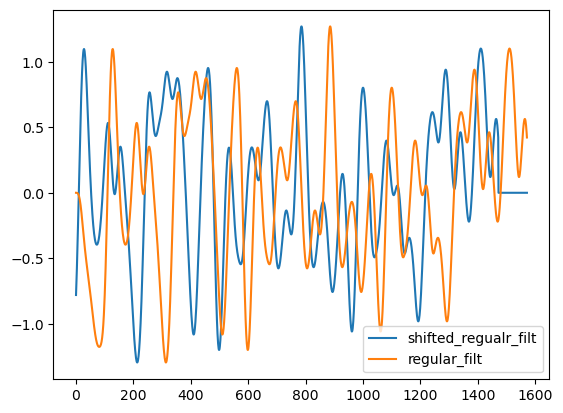

In [136]:
#testing shifting 
shifted_filter= create_shifted_array(filtered_regular_low,100)
plt.plot(shifted_filter, label="shifted_regualr_filt")
plt.plot(filtered_regular_low, label="regular_filt")
plt.legend()

Shifting function works!

Now we shift and find the value of "shift" for which the correlation is the maximum. 
As shown, the base correlation is pretty low because of the phase shift.

In [110]:
np.corrcoef(filtered_regular_low, filtered_zerophase_low)

array([[1.        , 0.10900015],
       [0.10900015, 1.        ]])

In [111]:
i=0
correlation_values_array= []
while i<1572/2:
    
    shifted_filter= create_shifted_array(filtered_regular_low,i)
    correlation_at_ithstep= np.corrcoef(shifted_filter, filtered_zerophase_low)[0,1]
    #print(shifted_filter)
    correlation_values_array.append([correlation_at_ithstep])
    #print(correlation_values_array)
    i+=1


In [112]:
np.max(correlation_values_array), np.argmax(correlation_values_array)

(0.9706423656569204, 34)

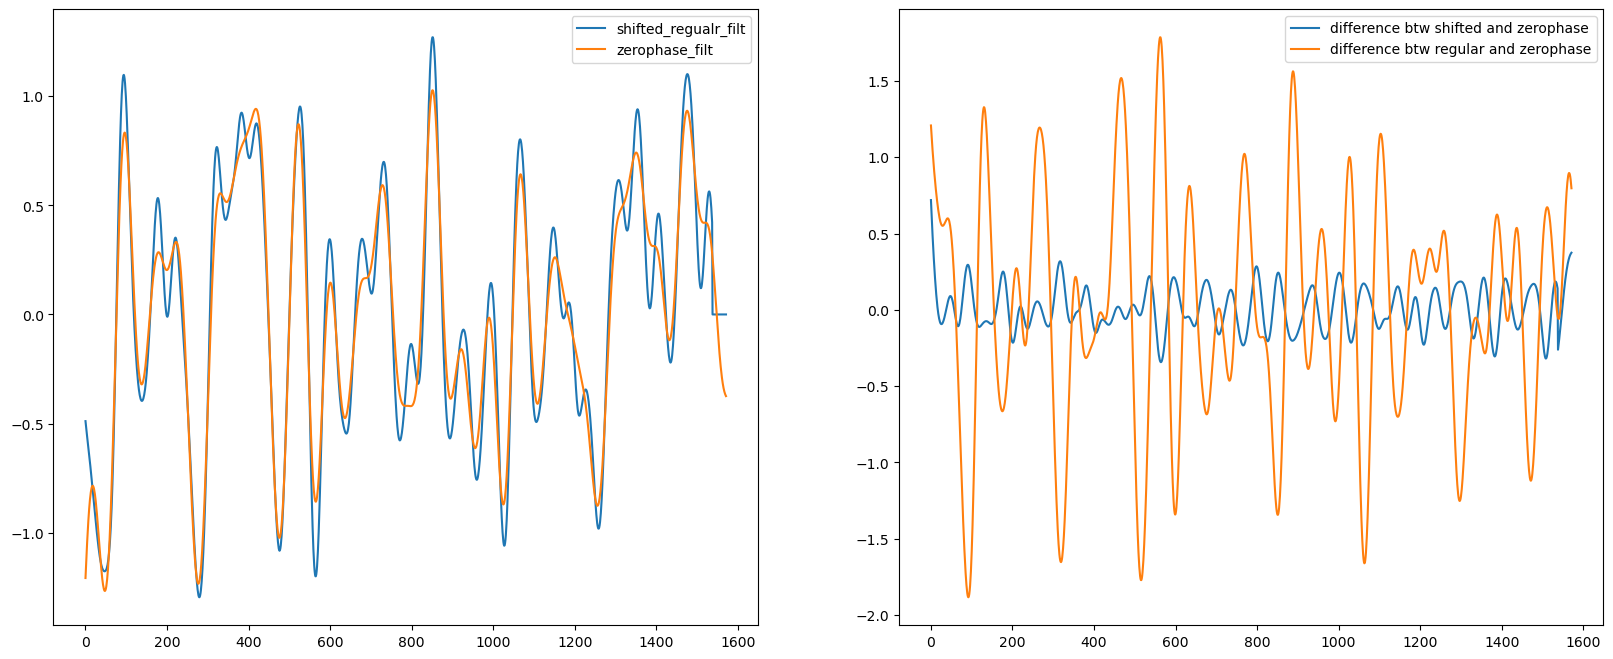

In [145]:
%matplotlib inline

shifted_filter= create_shifted_array(filtered_regular_low, np.argmax(correlation_values_array))
fig, ax= plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax[0].plot(shifted_filter, label="shifted_regualr_filt")
ax[0].plot(filtered_zerophase_low, label="zerophase_filt")
ax[0].legend()

ax[1].plot(shifted_filter- filtered_zerophase_low, label="difference btw shifted and zerophase")
ax[1].plot(filtered_regular_low- filtered_zerophase_low, label="difference btw regular and zerophase")

ax[1].legend()



So the phase shift is by 34, that is regular filter shifts it forward by 34 units of time. But phase shift is not the only difference, there is a difference in the magnitudes as well. 
<br>
Notice how phase shifting and then taking a difference reduces the "errors". The actual difference between regular and zerophase is not very apparent when difference in directly calculated without phase shifting.

### High pass filter
Following is for high pass 4th degree butterworth filter

In [98]:
sos = signal.butter(4, 1/72, 'high', fs=1, output='sos')
filtered_regular_high = signal.sosfilt(sos, pc1)

b, a = signal.butter(4, 1/72, 'high', fs=1)
filtered_zerophase_high = signal.filtfilt(b, a, pc1, padlen=None)


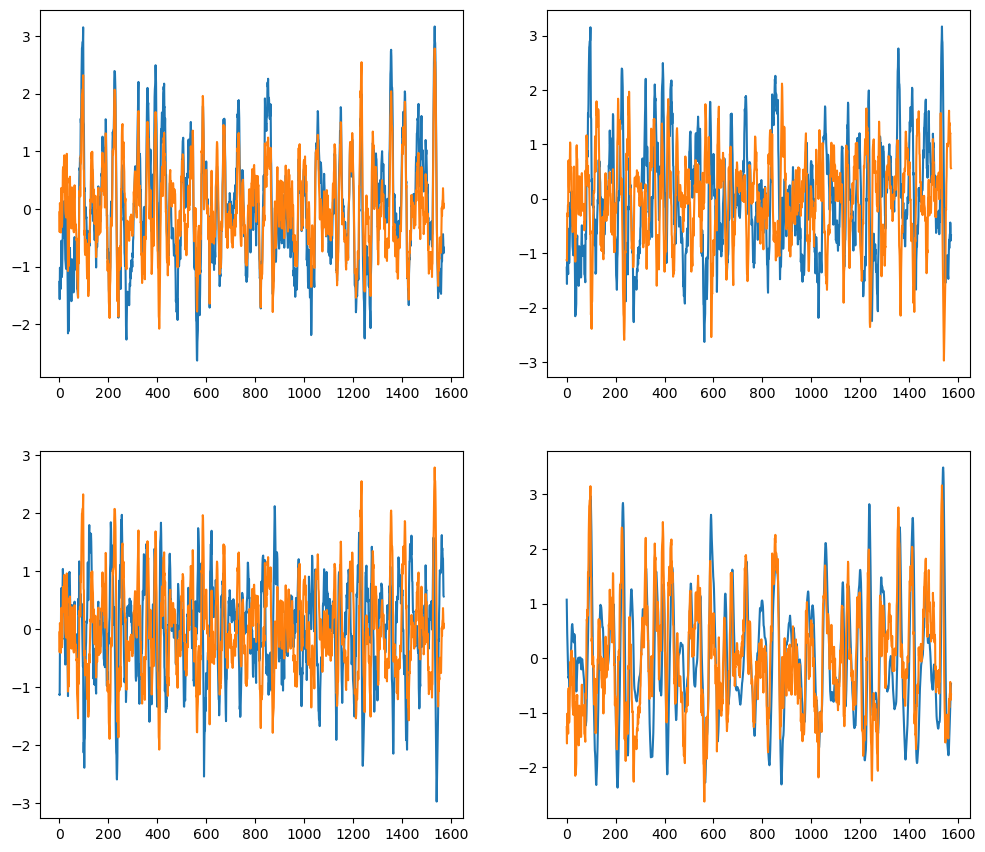

In [99]:
fig, ax= plt.subplots(nrows=2, ncols=2, figsize=(12,10.5))

ax[0,0].plot(pc1)
ax[0,0].plot(filtered_zerophase_high)

ax[0,1].plot(pc1)
ax[0,1].plot(filtered_regular_high)

ax[1,0].plot(filtered_regular_high)
ax[1,0].plot(filtered_zerophase_high)

ax[1,1].plot(filtered_zerophase_high - filtered_regular_high)
ax[1,1].plot(pc1)

Let's try and find how much the phase shift is.


In [152]:
i=0
correlation_values_array= []
while i<1572/2:
    
    shifted_filter= create_shifted_array(filtered_regular_high,i)
    correlation_at_ithstep= np.corrcoef(shifted_filter, filtered_zerophase_high)[0,1]
    #print(shifted_filter)
    correlation_values_array.append([correlation_at_ithstep])
    #print(correlation_values_array)
    i+=1


In [153]:
np.max(correlation_values_array), np.argmax(correlation_values_array)

(0.5770987283426215, 29)

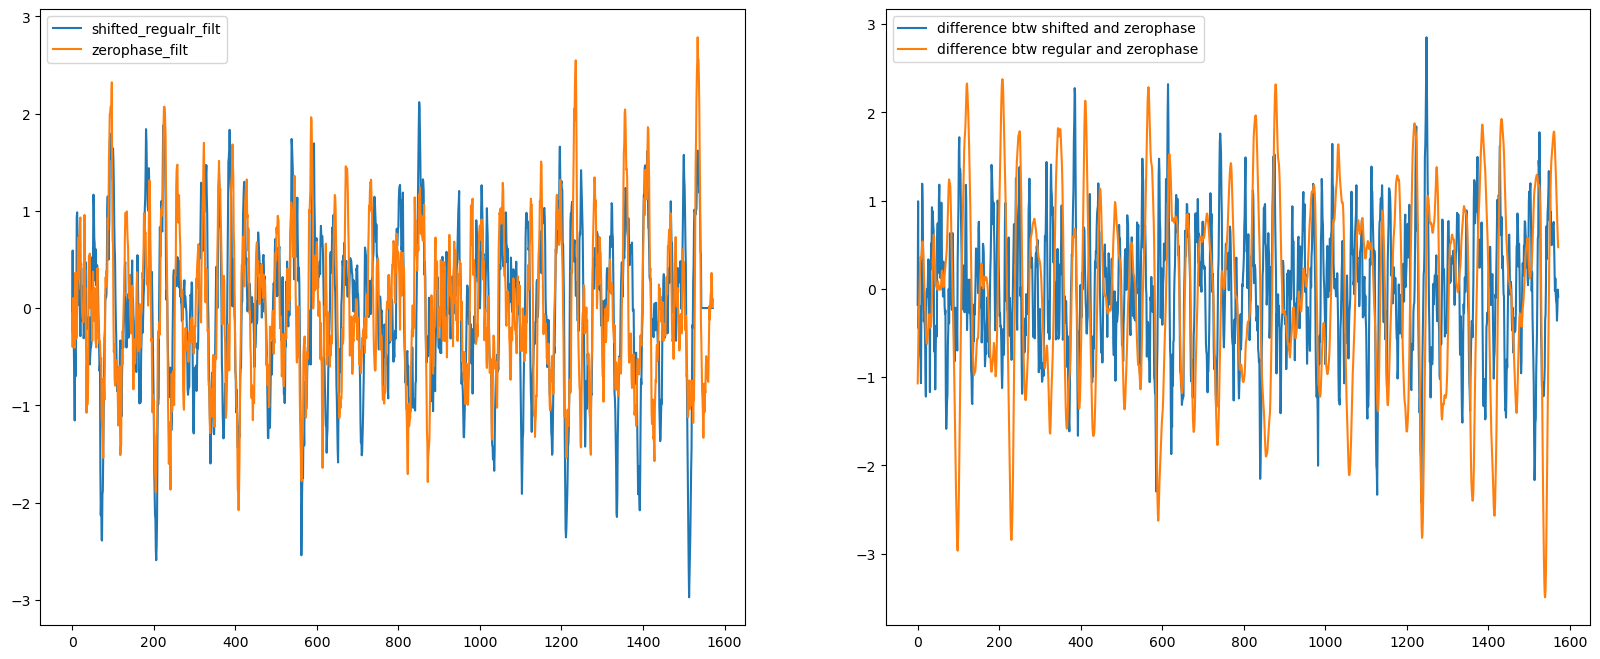

In [154]:
%matplotlib inline

shifted_filter_high= create_shifted_array(filtered_regular_high, np.argmax(correlation_values_array))
fig, ax= plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax[0].plot(shifted_filter_high, label="shifted_regualr_filt")
ax[0].plot(filtered_zerophase_high, label="zerophase_filt")
ax[0].legend()

ax[1].plot(shifted_filter_high - filtered_zerophase_high, label="difference btw shifted and zerophase")
ax[1].plot(filtered_regular_high - filtered_zerophase_high, label="difference btw regular and zerophase")

ax[1].legend()

Here the difference is very noisy and the phase shift is unclear because max correlation is only 0.577 which isn't a lot.<br> This is mostly likely to do with the fact that high pass filter is all frequencies after "per 72 months" frequency and hence phase shift due to all those frequencies have a cumulative effect on the filtered wave. 

4. Now that you have the low- and high-frequency components of PC1 separately, create a correlation map of SST with both these components and plot the resulting map. Interpret and describe the reasons for the patterns you obtain.

Let us create functions that do the following:
1. Make a array that contains info about about the correlation map. Each lat lon point has a time series data in the original sst data-xarray; this is correlated with the filtered PC1 and each correlation value is the data point for that given lat lon. This is then iterated over all lat lon points.
2. Convert the array generated into a xarray with two axis, lat and lon.

In [121]:
def create_correlation_map(given_data_set):
    array=[]
    for i in range(0, len(sst.coords['lat'])):
        for j in range(0, len(sst.coords['lon'])):
            slope= np.corrcoef(sst[:,i,j], given_data_set)[1,0]
            array.append(slope)
    return array

In [117]:
def convert_to_xarray (array):
    arrayfied_data = np.array(array).reshape(89, 180)
    
    data_array = xr.DataArray(arrayfied_data, dims = ['lat', 'lon'], coords = {'lat': sst.coords['lat'], 'lon': sst.coords["lon"]})
    
    return data_array

In [124]:
array_w_zerophase_high = create_correlation_map(filtered_zerophase_high)
array_w_zerophase_low = create_correlation_map(filtered_zerophase_low)

array_w_regular_high = create_correlation_map(filtered_regular_high)
array_w_regular_low = create_correlation_map(filtered_regular_low)


c:\Users\adity\.conda\envs\EC3134\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\adity\.conda\envs\EC3134\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


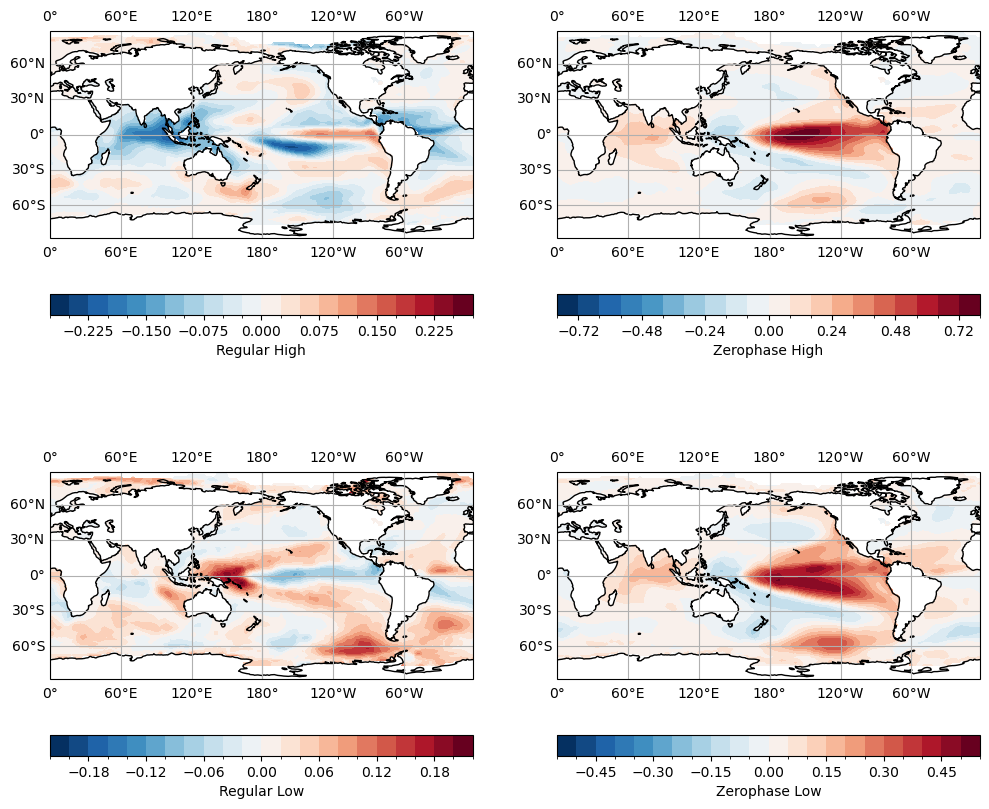

In [125]:
%matplotlib inline

fig, ax= plt.subplots(nrows=2, ncols=2, subplot_kw={'projection' : ccrs.PlateCarree(central_longitude=180)}, figsize=(12,10.5))

convert_to_xarray(array_w_regular_high).plot.contourf(ax=ax[0][0], cbar_kwargs = dict(orientation='horizontal',label='Regular High'), levels=25, transform=ccrs.PlateCarree())
convert_to_xarray(array_w_regular_low).plot.contourf(ax=ax[1][0], cbar_kwargs = dict(orientation='horizontal',label='Regular Low'), levels=25, transform=ccrs.PlateCarree())

convert_to_xarray(array_w_zerophase_high).plot.contourf(ax=ax[0][1], cbar_kwargs = dict(orientation='horizontal',label='Zerophase High'), levels=25, transform=ccrs.PlateCarree())
convert_to_xarray(array_w_zerophase_low).plot.contourf(ax=ax[1][1], cbar_kwargs = dict(orientation='horizontal',label='Zerophase Low'), levels=25, transform=ccrs.PlateCarree())


ax[0][0].coastlines()
ax[1][1].coastlines()
ax[0][1].coastlines()
ax[1][0].coastlines()

ax[0][0].gridlines(draw_labels=True,crs=ccrs.PlateCarree())
ax[1][1].gridlines(draw_labels=True,crs=ccrs.PlateCarree())
ax[0][1].gridlines(draw_labels=True,crs=ccrs.PlateCarree())
ax[1][0].gridlines(draw_labels=True,crs=ccrs.PlateCarree())


We see a stark difference between regular and zerophase filters. I will ignore the regular filtered pc1 as it doesnt seem very reliable due to the phase shift. <br>
There is some difference in the high and low zerophase filtered data. Some events are more pronounced in the low zerophase filter, like the El Nino Southern Oscillation, and some are more pronounced in the high zerophase filter, like the interdecadal oscillation.<br><br>
Let us look at the difference between the two!  

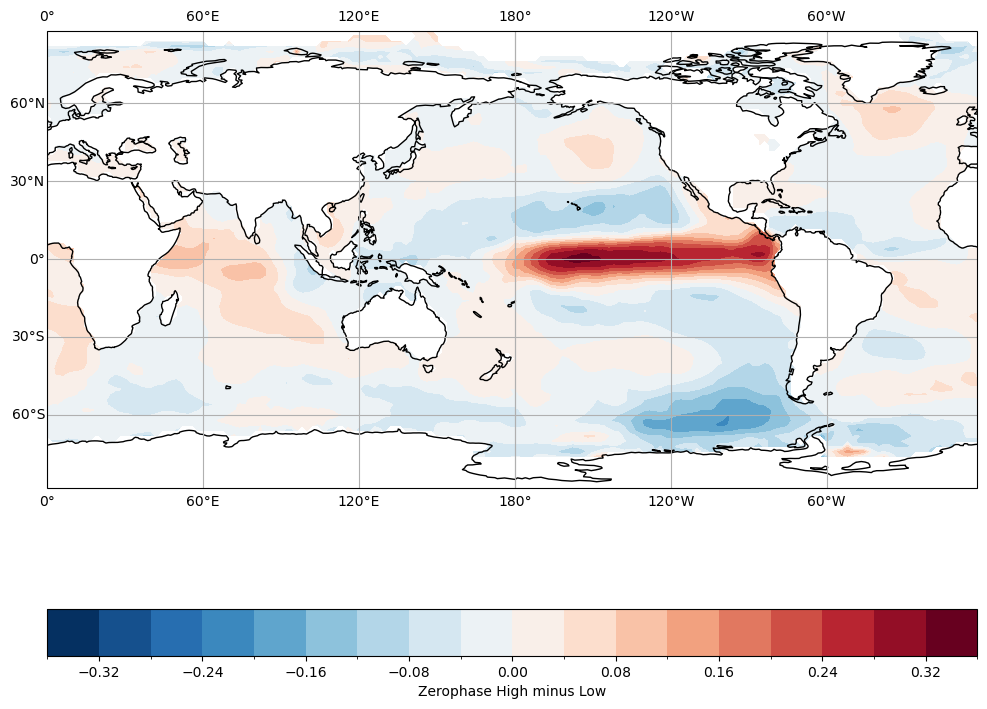

In [217]:
%matplotlib inline

fig, ax= plt.subplots(nrows=1, ncols=1, subplot_kw={'projection' : ccrs.PlateCarree(central_longitude=180)}, figsize=(12,10.5))
difference=convert_to_xarray(array_w_zerophase_high)-convert_to_xarray(array_w_zerophase_low)
difference.plot.contourf(ax=ax, cbar_kwargs = dict(orientation='horizontal',label='Zerophase High minus Low'), levels=20, transform=ccrs.PlateCarree())


ax.coastlines()
ax.gridlines(draw_labels=True,crs=ccrs.PlateCarree())

The above shows the things present in the High pass filtered data that is not present in the Low pass filtered data. Here we can see that Interdecadal pacific oscilation, which is a 15 to 30 year timescale event and hence is filtered out of our low pass filtered correlation map. The mid band of heating is probably also a freature that has a higher timescale than 6 years and hence shows up in the difference.<br><br>
Filtering helps us narrow down the data, and only look at events with the desired periodiciities which greatly helps with the analysis.
